## Import libraries 

In [118]:
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import tree, inspection, metrics
from sklearn.datasets import fetch_california_housing
from itertools import combinations, chain

## Preliminary tasks

* Disable FutureWarning alerts.
* Disable UserWarning alerts.

In [66]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Model parameters and user-defined inputs

In [67]:
target_names = "MedianHouseValue"
training_set_fraction = 0.6

## Load the California Housing dataset 

From Scikit-Learn:

This dataset was obtained from the StatLib repository. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surprisingly large values for block groups with few households and many empty houses, such as vacation resorts.

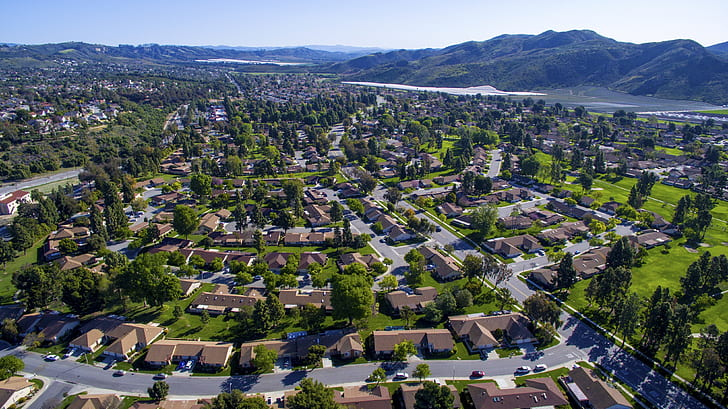

Source: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [68]:
# Load the california housing data from scikit-learn
ca_housing_data = fetch_california_housing(as_frame=True)
# Split the dataframe into features and targets
features = ca_housing_data["data"]
target = ca_housing_data["target"]
# Rename the target series
target.name = target_names
# Combine features and targets into a single dataset
ca_housing_df = pd.concat([features, target], axis=1)
# Store the feature names
feature_names = list(features.columns)
# Print dataset head
print(ca_housing_df.head(5))

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedianHouseValue  
0    -122.23             4.526  
1    -122.22             3.585  
2    -122.24             3.521  
3    -122.25             3.413  
4    -122.25             3.422  


## Descriptive analysis of the dataset

* Longitude: A measure of how far west a house is; a more negative value is farther west. Longitude values range from -180 to +180. Data set min: -124.3. Data set max: -114.3. Type: float64.
* Latitude: A measure of how far north a house is; a higher value is farther north. Latitude values range from -90 to +90. Data set min: 32.5. Data set max: 42.5. Type: float64.
* HousingMedianAge: Median age of a house within a block; a lower number is a newer building. Data set min: 1.0. Data set max: 52.0. Type: float64.
* TotalRooms: Total number of rooms within a block. Data set min: 2.0. Data set max: 37937.0. Type: float64.
* TotalBedrooms: Total number of bedrooms within a block. Data set min: 1.0. Data set max: 6445.0. Type: float64.
* Population: Total number of people residing within a block. Data set min: 3.0. Data set max: 35682.0. Type: float64.
* Households: Total number of households, a group of people residing within a home unit, for a block. Data set min: 1.0. Data set max: 6082.0. Type: float64
* MedianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars). Data set min: 0.5. Data set max: 15.0. Type: float64.
* MedianHouseValue: Median house value for households within a block (measured in US Dollars). Data set min: 14999.0. Data set max: 500001.0. Type: float64.

Source: https://developers.google.com/machine-learning/crash-course/california-housing-data-description

In [69]:
ca_housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Visualize static relationships between features and targets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


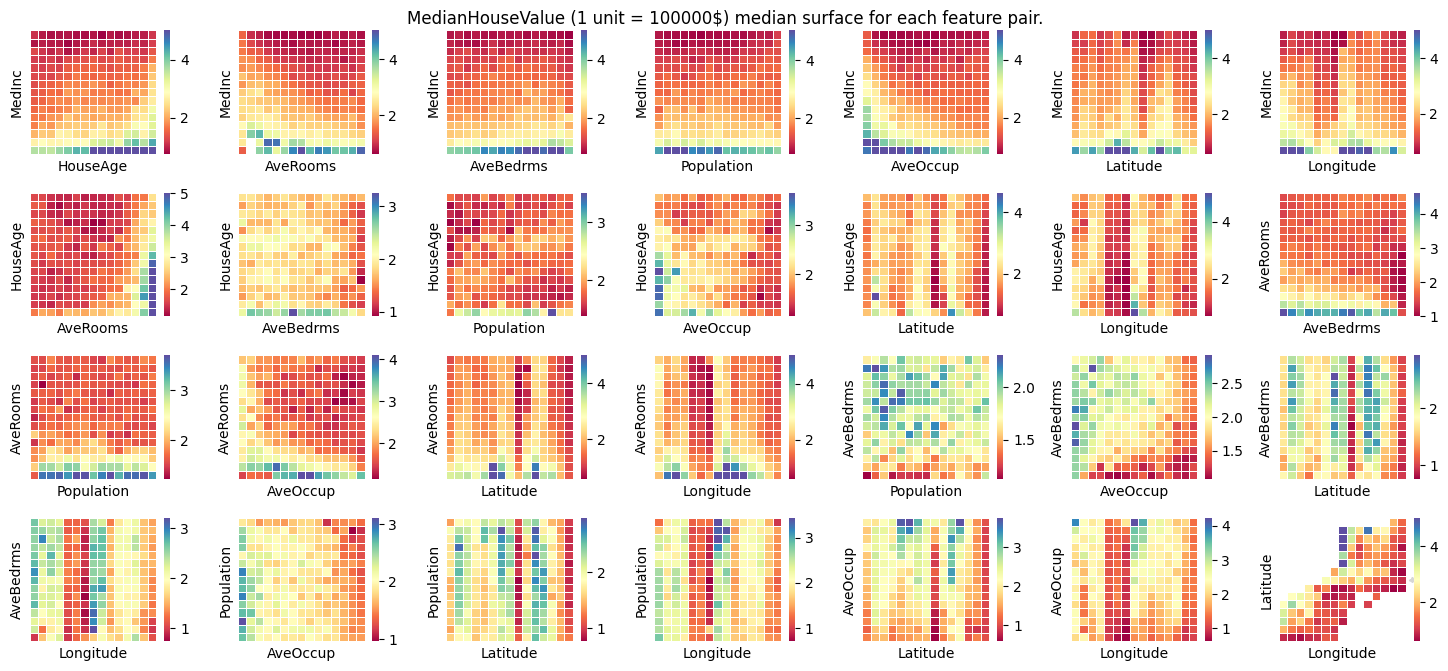

In [70]:
'''
Auxiliary methods to determine an "optimal" shape for a pairwise subplot
'''
def subplot_shape(n):
    # retrieve all the factors of a given integer
    factors = set(chain.from_iterable((i, n//i) for i in range(1, int(n**0.5)+1) if n % i == 0))
    # if n is a perfect square returns n_rows = n_columns = sqrt(n)
    if np.sqrt(n) in factors:
        return int(np.sqrt(n)), int(np.sqrt(n))
    # otherwise, split the factors greater/smaller than sqrt(n) and find a suitable pair a, b such that a x b = n
    else:
        factors_smaller_than_square_root = [f for f in factors if f < np.sqrt(n)]
        factors_smaller_than_square_root.sort(reverse=True)
        factors_greater_than_square_root = [f for f in factors if f > np.sqrt(n)]
        factors_greater_than_square_root.sort()
        for f_up in factors_greater_than_square_root:
            for f_down in factors_smaller_than_square_root:
                if (f_up*f_down == n):
                    return f_down, f_up
        # if the simple loop above fails to detect an adequate subplot shape (a,b), enforce a (1,n) shape
        return 1, n

def plot_features_pair_heatmap(X, y, plot_colors = "ryb", plot_step = 0.02):  
    # number of features
    n_features = X.shape[1]
    # generate all the possible pairs of features. These pairs are used
    # to filter the features dataframe to retain two columns. note that the number of pairs is
    # n_features^2 - sum(j = 1:n_features)j
    feature_pairs = [list(pair) for pair in list(combinations(list(X.columns),2))]
    # find the subplot rows and columns based on the number of features pairs
    subplot_rows, subplot_columns = subplot_shape(len(feature_pairs))
    # create a subplot grid
    fig, axes = plt.subplots(subplot_rows, subplot_columns, figsize = (15, 7))
    # loop over each index pair
    import matplotlib.ticker as ticker
    for pairidx, pair in enumerate(feature_pairs):
        # filter the features matrix to retain the two features columns corresponding to the current columns pair
        X_subset = X.loc[:, pair]
        # bin the features through a q-cut by deciles
        for feature in pair:
            features_binning_structure = pd.qcut(X_subset[feature],15,labels=False, retbins=True, precision=2)
            X_subset[feature] = [features_binning_structure[1][bin_idx] for bin_idx in features_binning_structure[0]]
        # transform the input dataset into a pivot table that can be used to build a heatmap
        heatmap_data = pd.pivot_table(pd.concat([X_subset, y], axis=1), values=y.name, index=pair[0], columns=pair[1], aggfunc = np.median)
        # identify current axes index of the subplot grid
        current_row = pairidx//subplot_columns
        current_column = pairidx%subplot_columns
        # build a heatmap where the current two features form the the axis and the color follows the median of the target variable
        sns.heatmap(heatmap_data, annot=False, cmap="Spectral", fmt=".2f", linewidths=.5, 
                    xticklabels=False, yticklabels=False, ax=axes[current_row][current_column]) 
    # enforce a tight layout
    plt.tight_layout(h_pad=1.0, w_pad=1.0, pad=2.5)
    # add final details to the figure
    plt.suptitle("{0} (1 unit = 100000$) median surface for each feature pair.".format(y.name))
    plt.legend(borderpad=0, handletextpad=0, loc=(1.05, 0.5))
    _ = plt.axis("tight")
    

plot_features_pair_heatmap(features, target)

## Split the dataset (training, test)

In [71]:
# Find the index of the splitting point
split_index = int(features.shape[0]*training_set_fraction)
# Build training set and training targets
X_train = features.values[0:split_index,:]
y_train = target.values[0:split_index]
# Build test set and test targets
X_test = features.values[split_index:,:]
y_test = target.values[split_index:]

## Build a simple decision tree regressor and train the model

A decision tree model can be build by appling a specific algorithm to a given dataset. Typical decision-tree algorithms are:

* ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

* C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it.

* C5.0 is Quinlan’s latest version release under a proprietary license. It uses less memory and builds smaller rulesets than C4.5 while being more accurate.

* CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

scikit-learn uses an optimized version of the CART algorithm; however, the scikit-learn implementation does not support categorical variables for now.

Source: https://scikit-learn.org/stable/modules/tree.html

In [72]:
# Build a tree model classifier object
clf = tree.DecisionTreeRegressor()
# Fit the model
clf = clf.fit(X_train, y_train)

## Predict the value of the target variable for each sample of the test set

In [92]:
# predict the target variable 
y_hat = clf.predict(X_test)

## Evaluate forecasts and inspect residuals

* $R^2$: this metric quantifies the fraction of target variable variance that can be explained by the predictors.
* $MAE$: this metric measures the mean absolute difference between values of the target variable and the corresponding predictions.
* $MSE$: this metric measures the mean squared difference between values of the target variable and the corresponding predictions.

In [113]:
# print major regression metrics
print("The coefficient of determination R^2 is: {:.3f}".format(metrics.r2_score(y_test, y_hat)))
print("The mean absolute error MAE is: {:.3f}".format(metrics.mean_absolute_error(y_test, y_hat)))
print("The mean squared error MSE is: {:.3f}".format(metrics.mean_squared_error(y_test, y_hat)))

The coefficient of determination R^2 is: 0.434
The mean absolute error MAE is: 0.609
The mean squared error MSE is: 0.770


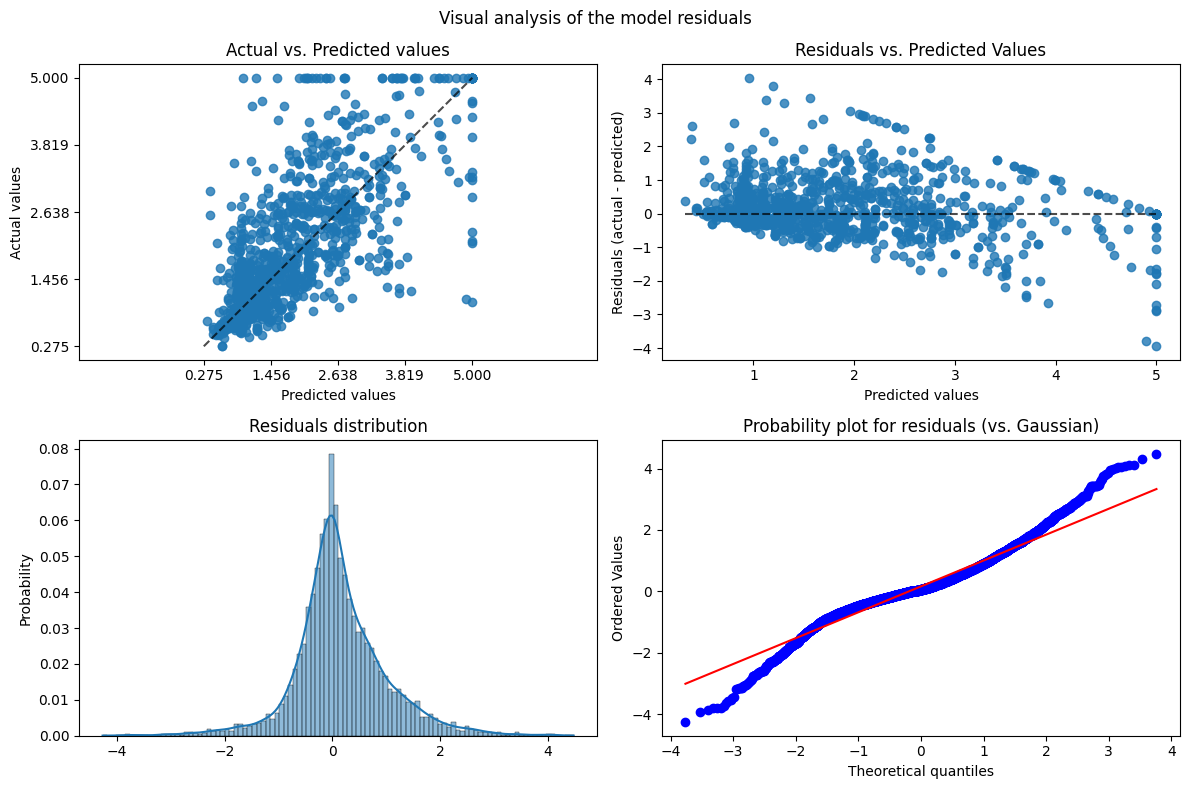

In [123]:
# build a visual inspection of residuals
fig, ax = plt.subplots(2,2, figsize=(12,8))
metrics.PredictionErrorDisplay.from_predictions(y_true=y_test, 
                                                y_pred=y_hat, 
                                                kind="actual_vs_predicted", 
                                                ax=ax[0][0], 
                                                random_state=0)
ax[0][0].set_title("Actual vs. Predicted values")
metrics.PredictionErrorDisplay.from_predictions(y_true=y_test, 
                                                y_pred=y_hat, 
                                                kind="residual_vs_predicted", 
                                                ax=ax[0][1], 
                                                random_state=0)
ax[0][1].set_title("Residuals vs. Predicted Values")
sns.histplot(y_test - y_hat, ax = ax[1][0], stat="probability", kde=True)
ax[1][0].set_title("Residuals distribution")
stats.probplot(y_test - y_hat, dist="norm", plot=ax[1][1])
ax[1][1].set_title("Probability plot for residuals (vs. Gaussian)")
fig.suptitle("Visual analysis of the model residuals")
plt.tight_layout()
plt.show()

## Compute features importance

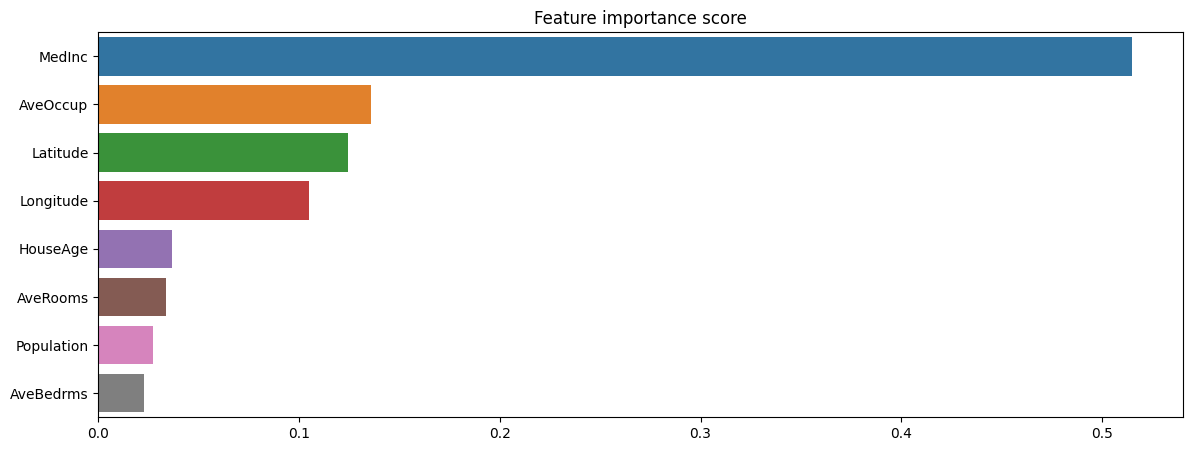

In [151]:
features_importance = dict((fname,np.round(i,4)) for fname, i in zip(feature_names, clf.tree_.compute_feature_importances(normalize=True)))
features_importance = sorted(features_importance.items(), key=lambda x:x[1], reverse=True)
fig, ax = plt.subplots(figsize=(14,5))
sns.barplot(y=[pair[0] for pair in features_importance],
            x=[pair[1] for pair in features_importance], 
            orient="h",
            ax=ax)
ax.set_title("Feature importance score")
plt.show()

## Regression tree pruning

Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting. This algorithm is parameterized by $\alpha > 0$ known as the complexity parameter. The complexity parameter is used to define the cost-complexity measure $R_{\alpha}(T)$, of a given tree $T$:

\begin{equation}
R_{\alpha}(T) = R(T) + \alpha|\tilde{T}|,
\end{equation}
where $|\tilde{T}|$ is the number of terminal nodes in $T$ and $R(T)$ is traditionally defined as the total misclassification rate of the terminal nodes. Alternatively, scikit-learn uses the total sample weighted impurity of the terminal nodes for $R(T)$. The impurity of a node depends on the criterion. Minimal cost-complexity pruning finds the subtree of $T$ that minimizes $R_{\alpha}(T)$.
The cost complexity measure of a single node is $R_{\alpha}(T) = R(T) + \alpha$. The branch, $T_t$, is defined to be a tree where node $t$ is its root. In general, the impurity of a node is greater than the sum of impurities of its terminal nodes, $R(T_t) < R(t)$ . However, the cost complexity measure of a node, $t$, and its branch, $T_t$, can be equal depending on $\alpha$. We define the effective $\alpha$ of a node to be the value where they are equal, $R_{\alpha}(T_t) = R_{\alpha}(t)$, i.e.
\begin{equation}
\alpha^{*} = \frac{R(t) - R(T_t)}{|T|-1}.
\end{equation}

A non-terminal node with the smallest value of $\alpha^*$ is the weakest link and will be pruned. This process stops when the pruned tree’s minimal $\alpha^{*}$ is greater than the ccp_alpha parameter.

Source: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

#### Cost complexity pruning alphas threshold vs. leaves impurity

Text(0.5, 1.0, 'Cost complexity pruning alpha threshold for training set vs. total impurity')

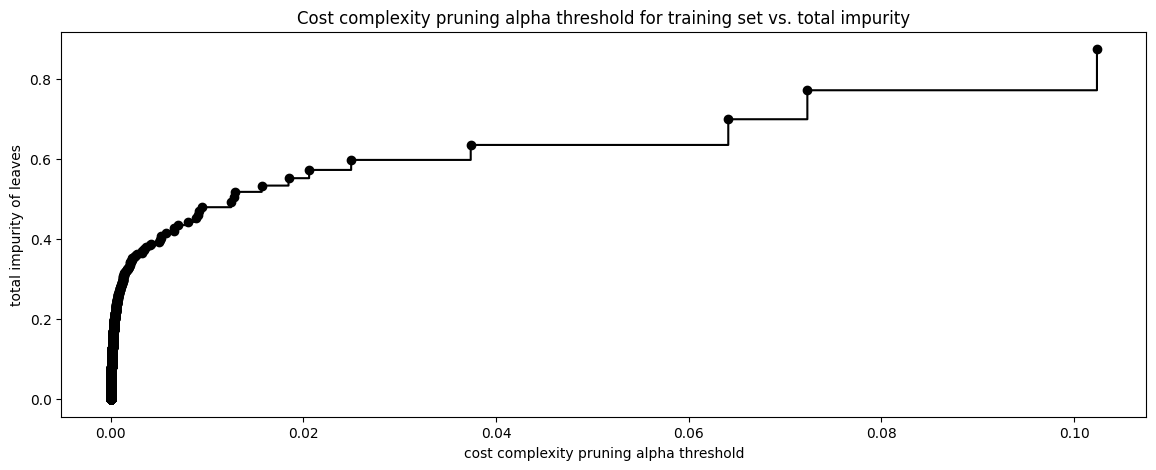

In [196]:
# initialize a decision tree regressor for pruning
clf_pruning = tree.DecisionTreeRegressor(random_state=0)
# retrieve the tree paths on the training data set
tree_path = clf_pruning.cost_complexity_pruning_path(X_train, y_train)
# retrieve the cost complexity pruning alphas and associated impurities
ccp_alphas, impurities = tree_path.ccp_alphas, path.impurities
# visualize the relationships between cost complexity pruning alphas and total impurity of leaves
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post", color="k")
ax.set_xlabel("cost complexity pruning alpha threshold")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Cost complexity pruning alpha threshold for training set vs. total impurity")

#### Optimize the state space of the experiment

In [189]:
# auxiliary method to detect the element of a list lst closest to a given value K
def find_closest_value(lst, K):
    index =  min(range(len(lst)), key = lambda i: abs(lst[i]-K))
    value = lst[index]
    return value
# retrieve the minimum and maximum ccp alphas thresholds
min_ccp_alphas = np.min(ccp_alphas)
max_ccp_alphas = np.max(ccp_alphas)
# calculate the delta alphas between two consecutives ccp alphas thresholds
ccp_alphas_step = (max_ccp_alphas - min_ccp_alphas)/200.0
# build an equally spaced grid of values for ccp alphas thresholds
ccp_alphas_grid = np.arange(min_ccp_alphas, max_ccp_alphas + ccp_alphas_step, ccp_alphas_step)
# select the ccp alphas values that best approximate (i.e., closest) each value of the theoretical alphas grid
selected_ccp_alphas = np.unique([find_closest_value(ccp_alphas, K) for K in ccp_alphas_grid])

#### Fit decision tree regressors for each ccp alpha threshold

In [190]:
# store the fits across the ccp alpha state spaces
clfs = []
# loop over the retained ccp alphas
for ccp_alpha in selected_ccp_alphas:
    # initialize and fit a decision tree regressor given the current ccp alpha
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    # append the model object
    clfs.append(clf)

#### Tree structure vs. ccp alpha threshold

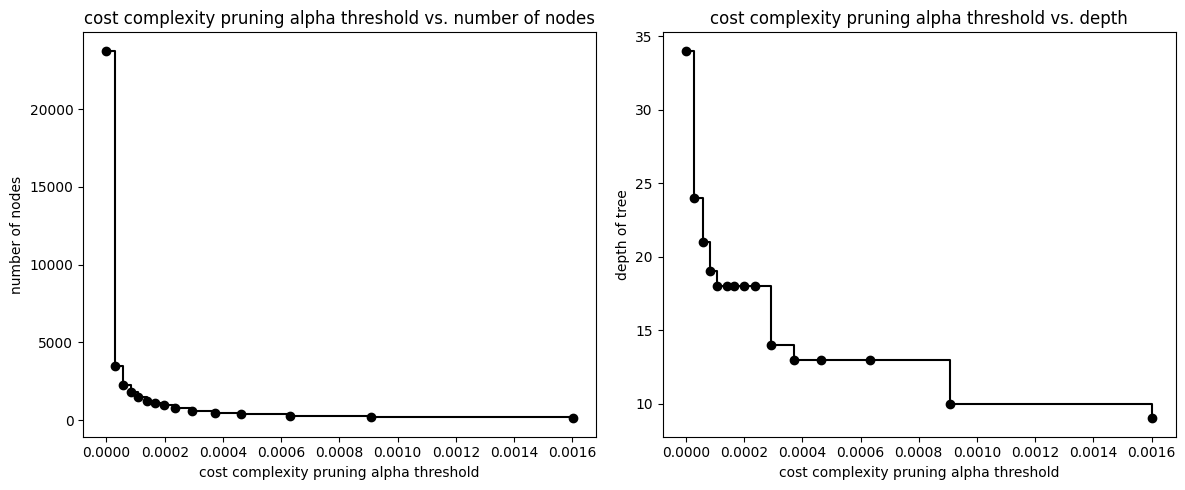

In [206]:
# retrieve the number of nodes in each model
node_counts = [clf.tree_.node_count for clf in clfs]
# retrieve the tree depth in each model
depth = [clf.tree_.max_depth for clf in clfs]
# plot the relationship between ccp alpha thresholds, node counts and depth
fig, ax = plt.subplots(1,2, figsize= (14,5))
ax[0].plot(selected_ccp_alphas, node_counts, marker="o", drawstyle="steps-post", color="k")
ax[0].set_xlabel("cost complexity pruning alpha threshold")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("cost complexity pruning alpha threshold vs. number of nodes")
ax[1].plot(selected_ccp_alphas, depth, marker="o", drawstyle="steps-post", color="k")
ax[1].set_xlabel("cost complexity pruning alpha threshold")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("cost complexity pruning alpha threshold vs. depth")
fig.tight_layout()

#### Performance metrics across the ccp alpha threshold spectrum

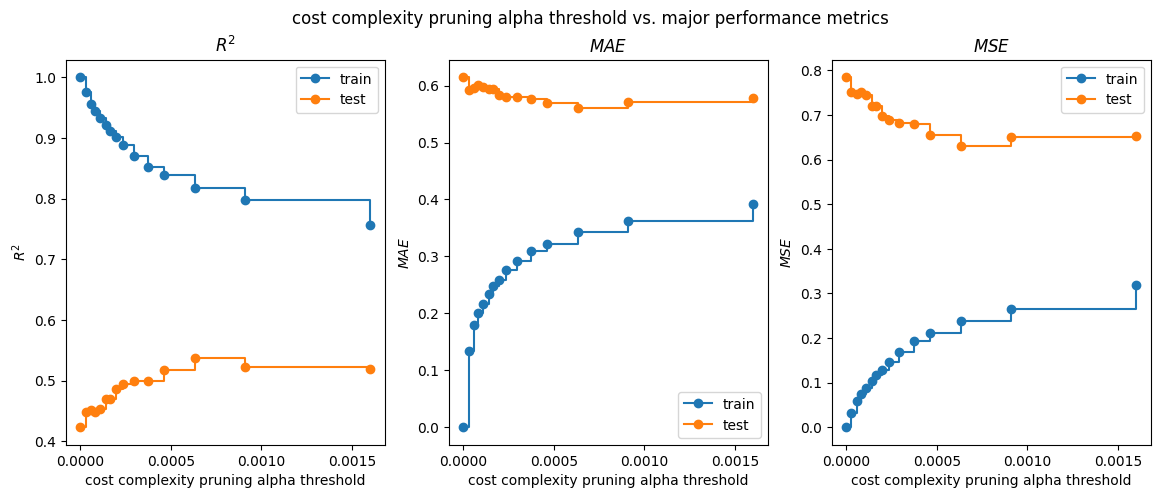

In [211]:
# calculate the R2 score for each model (training set and test set)
train_r2_scores = [metrics.r2_score(y_train, clf.predict(X_train)) for clf in clfs]
test_r2_scores = [metrics.r2_score(y_test, clf.predict(X_test)) for clf in clfs]
# calculate the MAE score for each model (training set and test set)
train_mae_scores = [metrics.mean_absolute_error(y_train, clf.predict(X_train)) for clf in clfs]
test_mae_scores = [metrics.mean_absolute_error(y_test, clf.predict(X_test)) for clf in clfs]
# calculate the MSE score for each model (training set and test set)
train_mse_scores = [metrics.mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]
test_mse_scores = [metrics.mean_squared_error(y_test, clf.predict(X_test)) for clf in clfs]
# plot each performance metrics vs. ccp alphas thresholds
fig, ax = plt.subplots(1,3,figsize=(14,5))
# R2
ax[0].set_xlabel("cost complexity pruning alpha threshold")
ax[0].set_ylabel(r'$R^2$')
ax[0].set_title(r'$R^2$')
ax[0].plot(selected_ccp_alphas, train_r2_scores, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(selected_ccp_alphas, test_r2_scores, marker="o", label="test", drawstyle="steps-post")
ax[0].legend()
# mae
ax[1].set_xlabel("cost complexity pruning alpha threshold")
ax[1].set_ylabel(r'$MAE$')
ax[1].set_title(r'$MAE$')
ax[1].plot(selected_ccp_alphas, train_mae_scores, marker="o", label="train", drawstyle="steps-post")
ax[1].plot(selected_ccp_alphas, test_mae_scores, marker="o", label="test", drawstyle="steps-post")
ax[1].legend()
# mse
ax[2].set_xlabel("cost complexity pruning alpha threshold")
ax[2].set_ylabel(r'$MSE$')
ax[2].set_title(r'$MSE$')
ax[2].plot(selected_ccp_alphas, train_mse_scores, marker="o", label="train", drawstyle="steps-post")
ax[2].plot(selected_ccp_alphas, test_mse_scores, marker="o", label="test", drawstyle="steps-post")
ax[2].legend()
plt.suptitle("cost complexity pruning alpha threshold vs. major performance metrics")
plt.show()